model_1.pth testing...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.16s/it]


process completed: OK


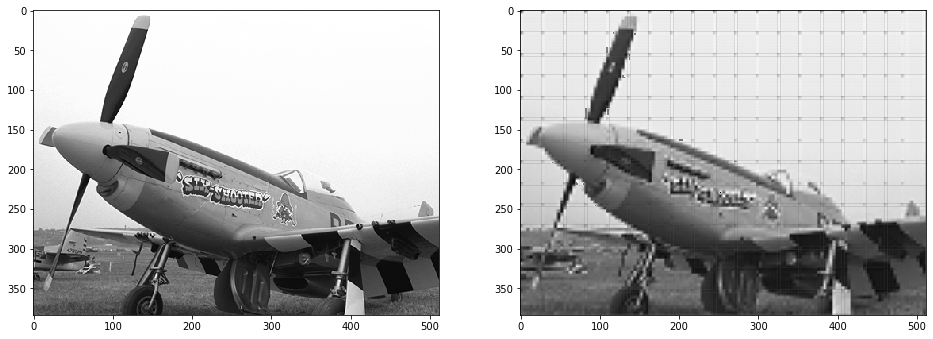

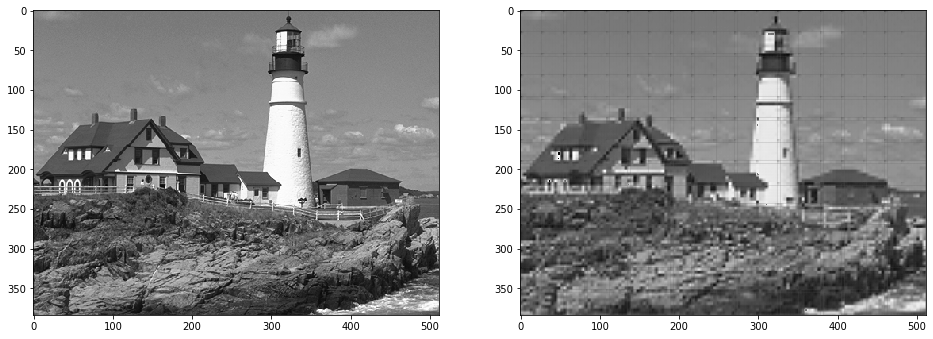

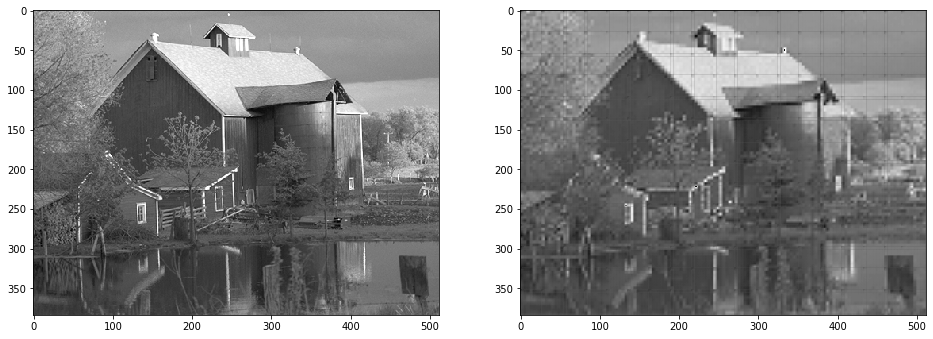

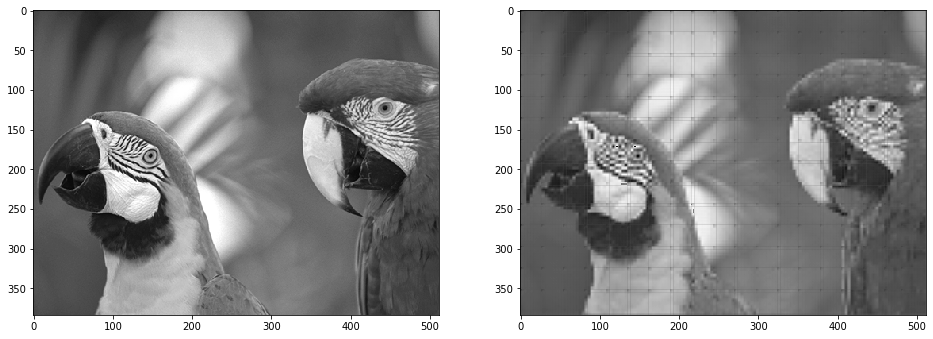

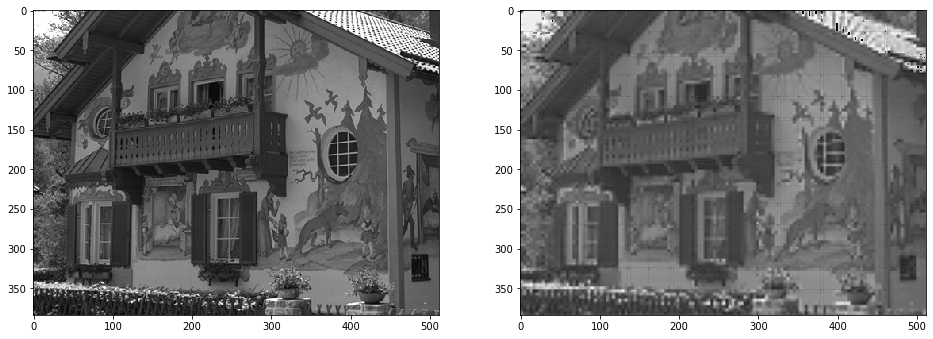

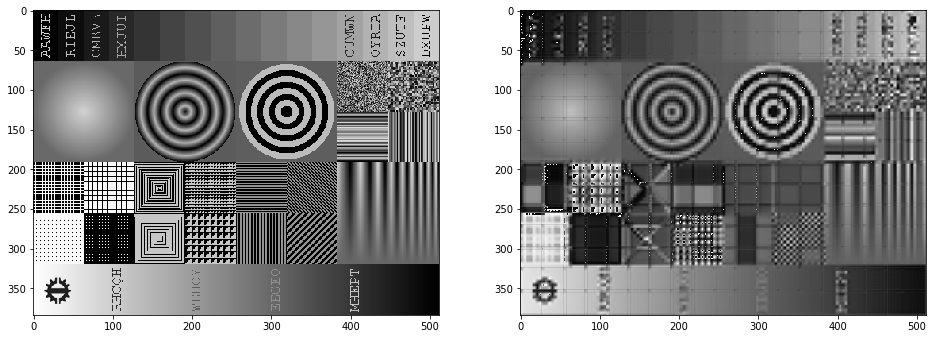

In [9]:
import sys, getopt
sys.path.append("../")
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, ToTensor
from torch.utils.data import ConcatDataset, DataLoader

from tqdm import tqdm

from utils import make_dataset_table, train_test_split
from dataset import DenoisingDataset
from loss import SSIMLoss, MSELoss
from model import AE
from conversion_transforms import ToNumpy


PATH_TO_DATA = './data_for_AE_test'
PATH_TO_DATASET_TABLE = './dataset.csv'
PATH_TO_RESULTS = './results'

TRAIN = True
TEST = True

NOISE_TYPES = ['1']
IMAGE_SIZE = (512, 384)
FRAME_SIZE = (32, 32) # (frame_width, frame_height)
OVERLAY_SIZE = (5, 5) # (stride_y, stride_x)
LATENT_CLEAN_SIZE = 0.9
BATCH_SIZE = 4
EPOCHS = 10

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def get_frame(image, frame_size, overlay_size, index, overlay_mask=None):
    """Getting frame from image (numpy.ndarray) in PIL Image format."""
    height, width, channels = image.shape
    frame_y, frame_x = frame_size
    overlay_y, overlay_x = overlay_size
    
    columns_number = (width - overlay_y) // (frame_y - overlay_y)
    if (width - overlay_y) % (frame_y - overlay_y) != 0:
        columns_number += 1
    
    row = index // columns_number
    column = index % columns_number
    
    end_y = min((column + 1) * frame_y - column * overlay_y, width)
    start_y = end_y - frame_y
    
    end_x = min((row + 1) * frame_x - row * overlay_x, height)
    start_x = end_x - frame_x
    
    if overlay_mask is not None:
        overlay_mask[start_x:end_x, start_y:end_y, :] += np.ones((frame_x, frame_y, channels))
        return image[start_x:end_x, start_y:end_y, :], overlay_mask
    return Image.fromarray(image[start_x:end_x, start_y:end_y, :].squeeze(axis=2))

def slicing(image, frame_size=(256, 256), overlay_size=(1, 1)):
    """Slicing image (numpy.ndarray) into frames list."""
    height, width, channels = image.shape
    frame_y, frame_x = frame_size
    overlay_y, overlay_x = overlay_size
    
    columns_number = (width - overlay_y) // (frame_y - overlay_y)
    if (width - overlay_y) % (frame_y - overlay_y) != 0:
        columns_number += 1
    
    rows_number = (height - overlay_x) // (frame_x - overlay_x)
    if (height - overlay_x) % (frame_x - overlay_x) != 0:
        rows_number += 1
    
    frames = []
    overlay_mask = np.zeros(image.shape)
    for index in range(columns_number * rows_number):
        frame, overlay_mask = get_frame(image, frame_size, overlay_size, index, overlay_mask)
        frames.append(frame)
    
    return frames, overlay_mask

def gluing(frames, overlay_mask, overlay_size=(1, 1)):
    """Gluing frames list ([numpy.ndarray, ...])
       into one image (numpy.ndarray in the range [0, 255]).
    """
    height, width, _ = overlay_mask.shape
    frame_x, frame_y, _ = frames[0].shape
    overlay_y, overlay_x = overlay_size
    
    image = np.zeros(overlay_mask.shape)
    start_x, start_y = (0, 0)
    end_x, end_y = frame_x, frame_y
    i = 0
    while 1:
        while 1:
            image[start_x:end_x, start_y:end_y, :] += frames[i]
            i += 1
            if end_y == width:
                break
            end_y = min(end_y + frame_y - overlay_y, width)
            start_y = end_y - frame_y
        if end_x == height:
            break
        end_x = min(end_x + frame_x - overlay_x, height)
        start_x = end_x - frame_x
        end_y = frame_y
        start_y = 0
    
    return (image / overlay_mask).astype(np.uint8)

def get_predicted_frames(model, frames):
    """Prediction of frames list ([numpy.ndarray, ...]) via model."""
    model.to('cpu')
    model.eval()
    predicted_frames = []
    for frame in frames:
        with torch.set_grad_enabled(False):
            tensor_frame = ToTensor()(np.array(frame)).unsqueeze(0)/1.0
            predicted_frame = model.decoder(torch.cat((model(tensor_frame)[0], model(tensor_frame)[1]), dim=3)).squeeze()
            
        predicted_frames.append(ToNumpy()(predicted_frame.unsqueeze(0)))
    
    return predicted_frames

def save_result(model, image, frame_size, overlay_size, path_to_save, figsize=(16, 9)):
    frames, overlay_mask = slicing(image, frame_size, overlay_size)
    predicted_frames = get_predicted_frames(model, frames)
    predicted_image = gluing(predicted_frames, overlay_mask, overlay_size)
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=figsize)
    axes[0].imshow(Image.fromarray(image.squeeze(axis=2)), 'gray')
    axes[1].imshow(Image.fromarray(predicted_image.squeeze(axis=2)), 'gray')
    
    fig.savefig(path_to_save, bbox_inches='tight')


def zero_corresp_rows(latent_vector, labels, num_latent_clean):
    """
    inp_tensor is torch.tensor of shape (batch_size, latent_dim)
    y_array is array of shape (batch_size,)
    """
    for index, label in enumerate(labels):
        if label == 'clean_image': # we should zero last components
            latent_vector[index, ..., num_latent_clean:] = 0 # in torch this works
        elif label == 'only_noise': # we should zero first components
            latent_vector[index, ..., :num_latent_clean] = 0 # in torch this works

    return latent_vector

def train_model(model, data_loader,
                loss, latent_loss,
                optimizer,
                epochs=EPOCHS,
                device=DEVICE):
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        print('Epoch {}/{}:'.format(epoch, epochs - 1), flush=True)

        running_loss = 0.0
        running_latent_loss = 0.0
        for images, labels in tqdm(data_loader):
            images = images.to(device)
            
            # Perform one step of minibatch stochastic gradient descent
            optimizer.zero_grad()
            model_latent_first, model_latent_last, model_output = model.forward(images)
            loss_total = loss(model_output, images)

            # now we will create tensor to compare with latent output
            model_latent = torch.cat((model_latent_first, model_latent_last), dim=3)
            
            model_latent_right = model_latent.detach().clone()
            model_latent_right = zero_corresp_rows(model_latent_right, labels, len(model_latent_first[0, 0, 0, :]))

            # finally combine losses
            loss_latent = latent_loss(model_latent, model_latent_right)
            loss_total += loss_latent

            loss_total.backward()
            optimizer.step()
            
            running_loss += loss_total.item()
            running_latent_loss += loss_latent.item()
            
        epoch_loss = running_loss / len(data_loader)
        epoch_latent_loss = running_latent_loss / len(data_loader)
        print('Total Loss: {:.4f}, Latent Loss: {:.4f}'.format(epoch_loss, epoch_latent_loss), flush=True)
        
    return model

def test_model(model, dataset, path_to_results):
    for image_number in tqdm(range(len(dataset))):
        path_to_image = dataset.iloc[image_number]['image']
        image = Image.open(path_to_image).convert('L') # PIL Image grayscale
        np_image = np.array(image)[..., np.newaxis] # numpy array from PIL Image
        
        path_to_save = os.path.join(path_to_results, os.path.basename(path_to_image))
        save_result(model, np_image, FRAME_SIZE, OVERLAY_SIZE, path_to_save, figsize=(16, 9))

if TRAIN:
    print('model training with parameters:\n'+
          'noise types = {}\n'.format(NOISE_TYPES)+
          'image size = {}\n'.format(IMAGE_SIZE)+
          'frame size = {}\n'.format(FRAME_SIZE)+
          'overlay size = {}\n'.format(OVERLAY_SIZE)+
          'latent clean size = {}\n'.format(LATENT_CLEAN_SIZE)+
          'batch size = {}\n'.format(BATCH_SIZE)+
          'number of epochs = {}\n'.format(EPOCHS))

    # dataset table creating
    make_dataset_table(PATH_TO_DATA, NOISE_TYPES, PATH_TO_DATASET_TABLE)
    train_test_split(PATH_TO_DATASET_TABLE, test_size=0.2)

    # dataset and dataloader creating
    torch.manual_seed(0)
    transforms = [Compose([RandomHorizontalFlip(p=1.0), ToTensor()]),
                  Compose([RandomVerticalFlip(p=1.0), ToTensor()]),
                  Compose([ColorJitter(brightness=(0.9, 2.0), contrast=(0.9, 2.0)), ToTensor()])]

    train_dataset = []
    for transform in transforms:
        dataset = DenoisingDataset(dataset=pd.read_csv(PATH_TO_DATASET_TABLE),
                                   image_size=IMAGE_SIZE,
                                   frame_size=FRAME_SIZE,
                                   overlay_size=OVERLAY_SIZE,
                                   phase='train',
                                   transform=transform)
        train_dataset = ConcatDataset([train_dataset, dataset])

    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True, # can be set to True only for train loader
                              num_workers=0)

    # model training
    model = AE(1, LATENT_CLEAN_SIZE)
    loss = SSIMLoss()
    latent_loss = MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
    model = train_model(model, train_loader,
                        loss, latent_loss,
                        optimizer,
                        epochs=EPOCHS,
                        device=DEVICE)

    # model saving
    path_to_model = './model' + '_{}'.format('_'.join([str(elem) for elem in NOISE_TYPES])) + '.pth'
    torch.save(model, path_to_model)

if TEST:    
    # model loading
    path_to_model = './model' + '_{}'.format('_'.join([str(elem) for elem in NOISE_TYPES])) + '.pth'
    print('{} testing...'.format(os.path.basename(path_to_model)))
    model = torch.load(path_to_model)

    dataset=pd.read_csv(PATH_TO_DATASET_TABLE)
    test_dataset = dataset[dataset['phase']=='test']

    # model testing and results saving
    path_to_results = PATH_TO_RESULTS + '_{}'.format('_'.join([str(elem) for elem in NOISE_TYPES]))
    if not os.path.exists(path_to_results):
        os.makedirs(path_to_results)
    test_model(model, test_dataset, path_to_results)

print('process completed: OK')